In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import multirecording_spikeanalysis_edit2 as spike
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

new_collection = {}

for recording in list(ephys_data.collection.keys()):
    # Determine the new key as per your requirement
    start_pos = recording.find('subj_')
    end_pos = start_pos + len('subj_') + 3
    recording_key_without_suffix = recording[:end_pos]

    # Check if this new key matches the keys in your timestamp_dicts
    if recording_key_without_suffix in timestamp_dicts:
        # Update the event_dict for the recording using the modified key
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract and assign the subject using the modified key
        subject = recording[start_pos + len('subj_'):end_pos]
        ephys_data.collection[recording].subject = subject

        # Add this recording to the new_collection with the updated key
        new_collection[recording_key_without_suffix] = ephys_data.collection[recording]
    else:
        # If not found in timestamp_dicts, simply carry the recording over without modification
        new_collection[recording] = ephys_data.collection[recording]

# Replace the old collection with the new one
ephys_data.collection = new_collection

# Continue with the spike analysis
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=100, smoothing_window=300, ignore_freq=0.5)

event_spikes = spike_analysis.generate_spiketrain_dataframe()

event_spikes

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class

,Recording,Event name,Event number,Unit number,Pre-event spike 1,Pre-event spike 2,Pre-event spike 3,Pre-event spike 4,Pre-event spike 5,Pre-event spike 6,...,Event spike 91,Event spike 92,Event spike 93,Event spike 94,Event spike 95,Event spike 96,Event spike 97,Event spike 98,Event spike 99,Event spike 100
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,85,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,85,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,85,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,85,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,85,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10016,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10017,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10018,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [2]:
event_spikes['Pre-event spike 1'].mean()

0.39600798403193616

In [3]:
event_spikes['Pre-event spike 1'].value_counts()

Pre-event spike 1
0     7555
1     1676
2      451
3      162
4       90
5       36
6       20
7       16
9        5
10       4
8        3
11       1
12       1
Name: count, dtype: int64

In [4]:
event_spikes['Event spike 1'].value_counts()

Event spike 1
0     7564
1     1755
2      405
3      162
4       67
5       31
6       17
7        6
8        5
9        4
10       2
11       1
12       1
Name: count, dtype: int64

In [5]:
# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

# Calculate 'Pre-event M' and 'Pre-event Std' for each row
pre_event_mean = event_spikes[pre_event_cols].mean(axis=1)
pre_event_std = event_spikes[pre_event_cols].std(axis=1).round(3)

# Normalize 'Event' columns based on 'Pre-event M' and 'Pre-event Std'
normalized_event_cols = event_spikes[event_cols].apply(lambda x: (x - pre_event_mean) / pre_event_std, axis=0)
normalized_event_cols = normalized_event_cols.replace([np.inf, -np.inf], np.nan)  # Handle division by zero by replacing infinities with NaN

# Calculate 'Event Z-Score' for each row
event_z_score = normalized_event_cols.mean(axis=1)

# Creating the final DataFrame with the calculated columns at the end
event_spikes_zscores_final = pd.concat([event_spikes, normalized_event_cols, pre_event_mean.rename('Pre-event M'), pre_event_std.rename('Pre-event Std'), event_z_score.rename('Event Z-Score')], axis=1)

event_spikes_zscores_final

,Recording,Event name,Event number,Unit number,Pre-event spike 1,Pre-event spike 2,Pre-event spike 3,Pre-event spike 4,Pre-event spike 5,Pre-event spike 6,...,Event spike 94,Event spike 95,Event spike 96,Event spike 97,Event spike 98,Event spike 99,Event spike 100,Pre-event M,Pre-event Std,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,85,0,1,0,0,0,0,...,-0.364964,-0.364964,-0.364964,-0.364964,-0.364964,-0.364964,-0.364964,0.15,0.411,-0.072993
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,85,0,0,0,0,0,0,...,-0.141844,-0.141844,-0.141844,-0.141844,-0.141844,-0.141844,-0.141844,0.02,0.141,-0.141844
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,85,0,0,0,0,0,0,...,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,0.01,0.100,0.200000
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,85,0,0,0,0,0,0,...,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,0.03,0.171,-0.058480
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,85,0,0,0,0,0,0,...,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,0.03,0.171,-0.175439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000,NaN
10016,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0,0,0,0,0,0,...,-0.134529,-0.134529,-0.134529,-0.134529,-0.134529,-0.134529,-0.134529,0.03,0.223,-0.044843
10017,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000,NaN
10018,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000,NaN


In [6]:
def custom_aggregate(z_scores):
    if len(z_scores) < 2:
        return '< 2 events'
    else:
        return z_scores.mean()

# Group by 'Recording', 'Event name', and 'Unit number', then apply the custom aggregation function
zscore_df = event_spikes_zscores_final.groupby(['Recording', 'Event name', 'Unit number'])['Event Z-Score'].apply(custom_aggregate).reset_index()

# Rename the column from the aggregation result to 'Z-score'
zscore_df.rename(columns={'Event Z-Score': 'Z-score'}, inplace=True)

zscore_df

,Recording,Event name,Unit number,Z-score
0,20230612_101430_standard_comp_to_training_D1_s...,lose,2,-0.024142
1,20230612_101430_standard_comp_to_training_D1_s...,lose,5,-0.117428
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,0.075553
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,0.033169
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,0.091453
...,...,...,...,...
797,20230625_112913_standard_comp_to_both_rewarded...,win,60,0.281825
798,20230625_112913_standard_comp_to_both_rewarded...,win,77,0.035138
799,20230625_112913_standard_comp_to_both_rewarded...,win,85,0.065548
800,20230625_112913_standard_comp_to_both_rewarded...,win,99,-0.049478


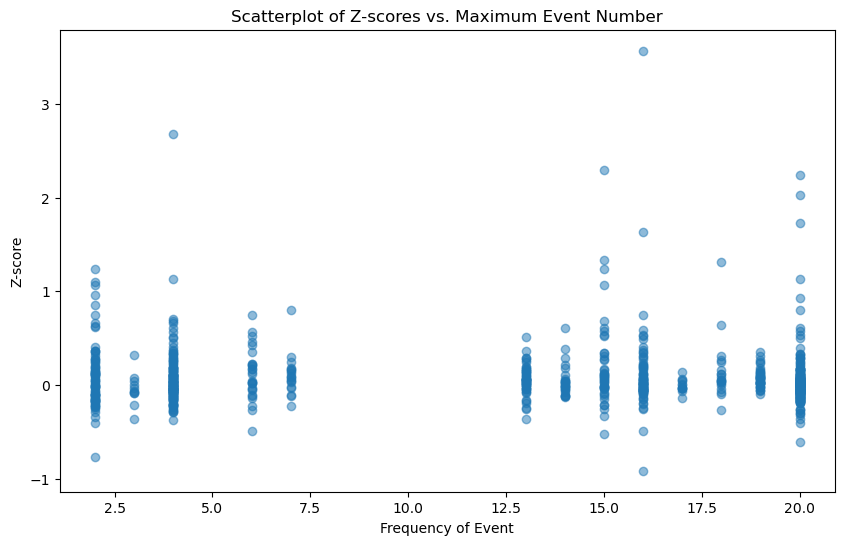

In [7]:
# Step 1: Find the maximum 'Event number' for each 'Recording' and 'Event name'
max_event_numbers = event_spikes_zscores_final.groupby(['Recording', 'Event name'])['Event number'].max().reset_index()
max_event_numbers.rename(columns={'Event number': 'Max Event number'}, inplace=True)

# Step 2: Merge this max event number data with the zscore_df
merged_df = pd.merge(zscore_df, max_event_numbers, on=['Recording', 'Event name'], how='left')

# Step 3: Plot the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Max Event number'], merged_df['Z-score'], alpha=0.5)
plt.title('Scatterplot of Z-scores vs. Maximum Event Number')
plt.xlabel('Frequency of Event')
plt.ylabel('Z-score')
# plt.grid(True)
plt.show()

In [8]:
merged_df['Max Event number'].value_counts()

Max Event number
20    217
4     157
16     86
2      80
13     54
15     46
19     43
6      28
14     28
18     20
7      19
17     13
3      11
Name: count, dtype: int64

In [9]:
event_spikes_zscores_final['Event number'].value_counts()

Event number
1     802
2     802
3     722
4     711
5     554
6     554
7     526
13    507
12    507
11    507
10    507
9     507
8     507
14    453
15    425
16    379
17    293
18    280
19    260
20    217
Name: count, dtype: int64

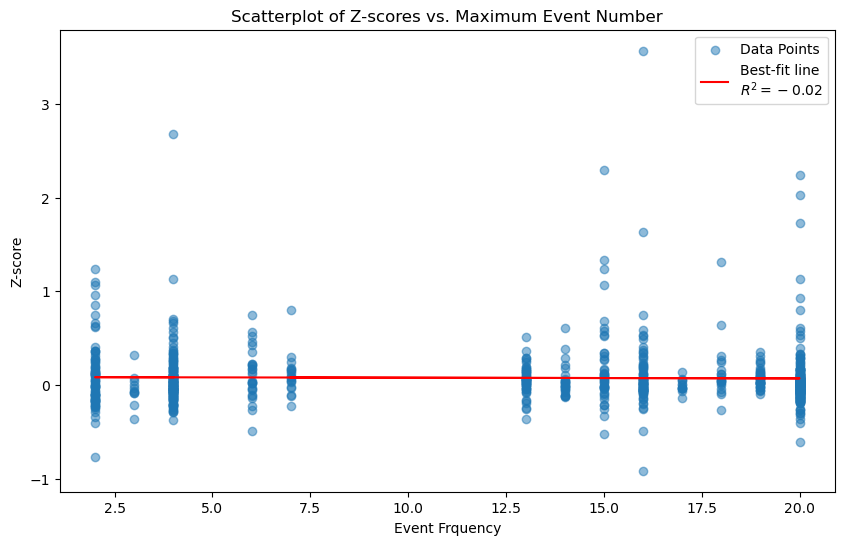

In [10]:
max_event_numbers = event_spikes_zscores_final.groupby(['Recording', 'Event name'])['Event number'].max().reset_index()
max_event_numbers.rename(columns={'Event number': 'Max Event number'}, inplace=True)

# Step 2: Merge this max event number data with the zscore_df
merged_df = pd.merge(zscore_df, max_event_numbers, on=['Recording', 'Event name'], how='left')

# Remove any NaN values that might affect correlation and regression analysis
merged_df.dropna(inplace=True)

# Calculate Pearson correlation coefficient
correlation_coef = np.corrcoef(merged_df['Max Event number'], merged_df['Z-score'])[0, 1]

# Fit line (polynomial of degree 1 i.e., linear)
fit = np.polyfit(merged_df['Max Event number'], merged_df['Z-score'], deg=1)
fit_fn = np.poly1d(fit)

# Step 3: Plot the scatterplot and best-fit line
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Max Event number'], merged_df['Z-score'], alpha=0.5, label='Data Points')
plt.plot(merged_df['Max Event number'], fit_fn(merged_df['Max Event number']), 'r-', label=f'Best-fit line\n$R^2 = {correlation_coef:.2f}$')

plt.title('Scatterplot of Z-scores vs. Maximum Event Number')
plt.xlabel('Event Frquency')
plt.ylabel('Z-score')
# plt.grid(True)
plt.legend()
plt.show()

Null values in Max Event number: 0
Null values in Z-score: 0

Statistics for Max Event number:
 count    802.000000
mean      12.493766
std        6.997634
min        2.000000
25%        4.000000
50%       15.000000
75%       20.000000
max       20.000000
Name: Max Event number, dtype: float64

Statistics for Z-score:
 count    802.000000
mean       0.076378
std        0.319613
min       -0.914018
25%       -0.063994
50%        0.022332
75%        0.129800
max        3.565966
Name: Z-score, dtype: float64


C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


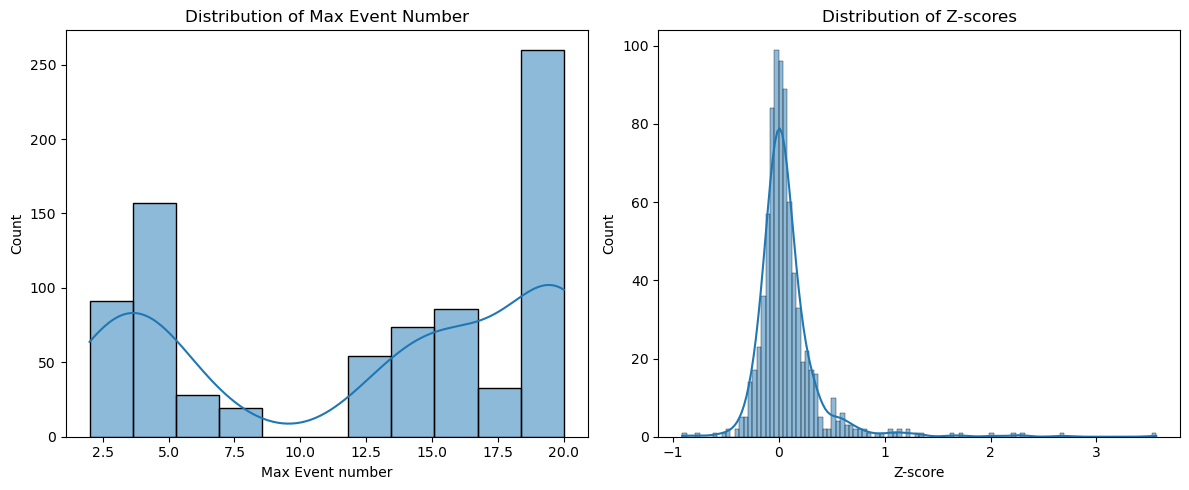

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


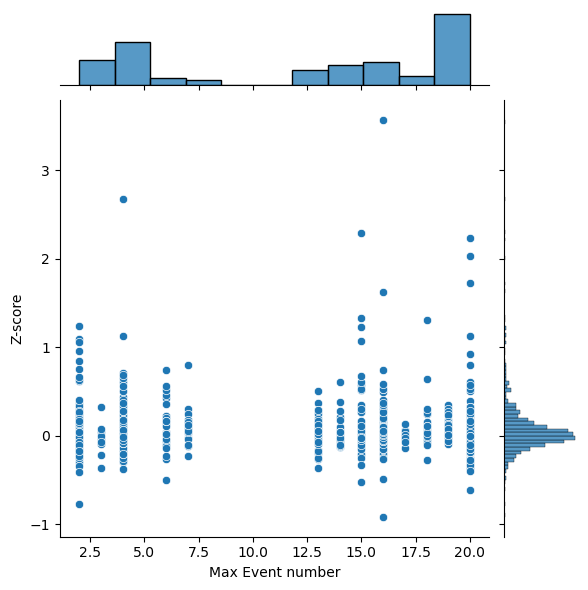


Correlation matrix:
                  Max Event number   Z-score
Max Event number          1.000000 -0.015479
Z-score                  -0.015479  1.000000


In [11]:
# Check for any null values in the important columns
print("Null values in Max Event number:", merged_df['Max Event number'].isnull().sum())
print("Null values in Z-score:", merged_df['Z-score'].isnull().sum())

# Basic statistics of these columns
print("\nStatistics for Max Event number:\n", merged_df['Max Event number'].describe())
print("\nStatistics for Z-score:\n", merged_df['Z-score'].describe())

# Plotting the distribution of 'Max Event number' and 'Z-score'
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(merged_df['Max Event number'], kde=True)
plt.title('Distribution of Max Event Number')

plt.subplot(1, 2, 2)
sns.histplot(merged_df['Z-score'], kde=True)
plt.title('Distribution of Z-scores')

plt.tight_layout()
plt.show()

# Scatter plot to visually inspect the relationship
sns.jointplot(x='Max Event number', y='Z-score', data=merged_df, kind="scatter")
plt.show()

# Correlation matrix for a numerical check
print("\nCorrelation matrix:")
print(merged_df[['Max Event number', 'Z-score']].corr())

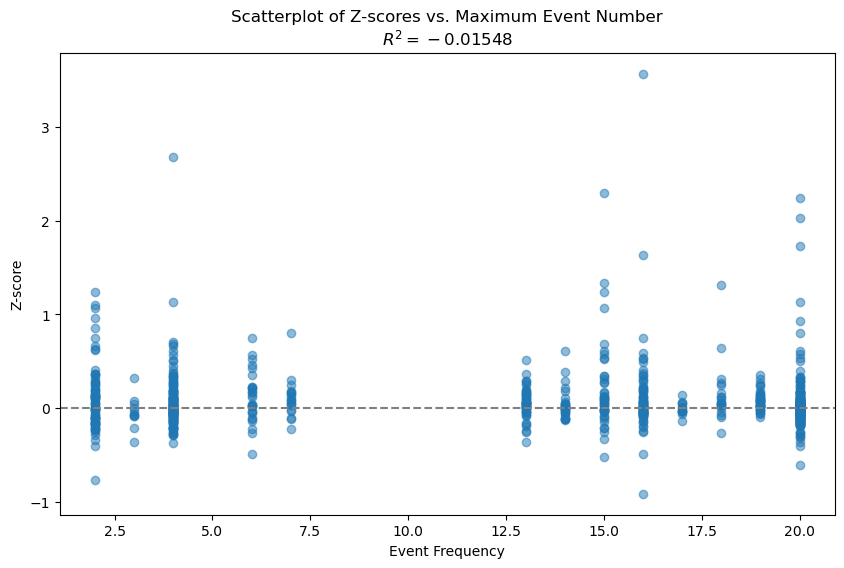

In [12]:
# Step 2: Merge this max event number data with the zscore_df
merged_df = pd.merge(zscore_df, max_event_numbers, on=['Recording', 'Event name'], how='left')

# Remove any NaN values that might affect correlation and regression analysis
merged_df.dropna(inplace=True)

# Calculate Pearson correlation coefficient
correlation_coef = np.corrcoef(merged_df['Max Event number'], merged_df['Z-score'])[0, 1]

# Step 3: Plot the scatterplot without the best-fit line
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Max Event number'], merged_df['Z-score'], alpha=0.5, label='Data Points')

# Add a horizontal dashed line at y=0
plt.axhline(y=0, color='gray', linestyle='--')

plt.title(f'Scatterplot of Z-scores vs. Maximum Event Number\n$R^2 = {correlation_coef:.5f}$')
plt.xlabel('Event Frequency')
plt.ylabel('Z-score')

plt.show()
# plt.savefig('ZScore_Scatterplot.png', bbox_inches='tight')

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


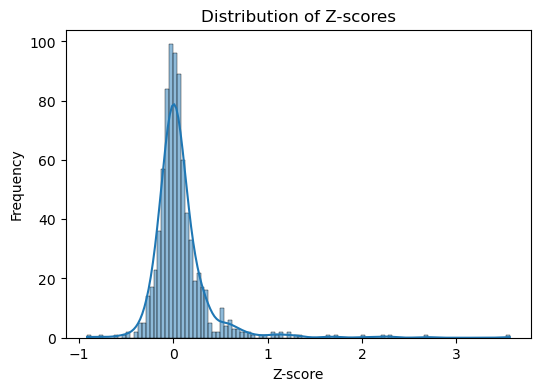

In [13]:
# Plotting the distribution of 'Z-score'
plt.figure(figsize=(6, 4))  # Adjust size as needed
sns.histplot(merged_df['Z-score'], kde=True)
plt.title('Distribution of Z-scores')
plt.xlabel('Z-score')
plt.ylabel('Frequency')

# Save the plot to a file
plt.show()
# plt.savefig('ZScore_Histogram.png', dpi=300)  # dpi can be adjusted based on required resolution

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


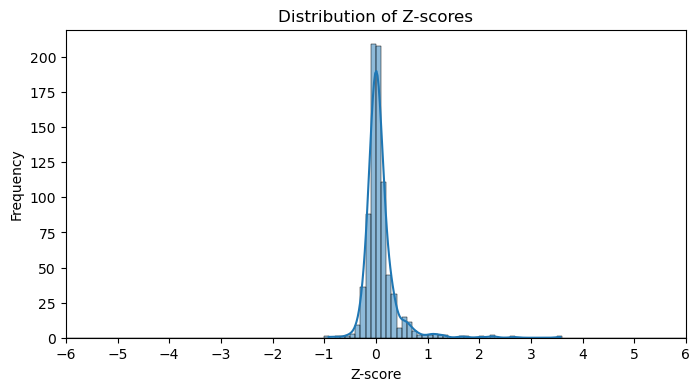

In [18]:
# Plotting the distribution of 'Z-score'
plt.figure(figsize=(8, 4))  # Adjust size as needed
sns.histplot(merged_df['Z-score'], kde=True, binwidth=0.1, binrange=(-6, 6))
plt.title('Distribution of Z-scores')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.xlim(-6, 6)  # Limiting the x-axis to focus from -6 to 6

# Setting x-axis ticks to show every integer from -6 to 6
plt.xticks(range(-6, 7))

# Save the plot to a file
plt.show()
# plt.savefig('ZScore_Histogram.png', dpi=300)  # dpi can be adjusted based on required resolution

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


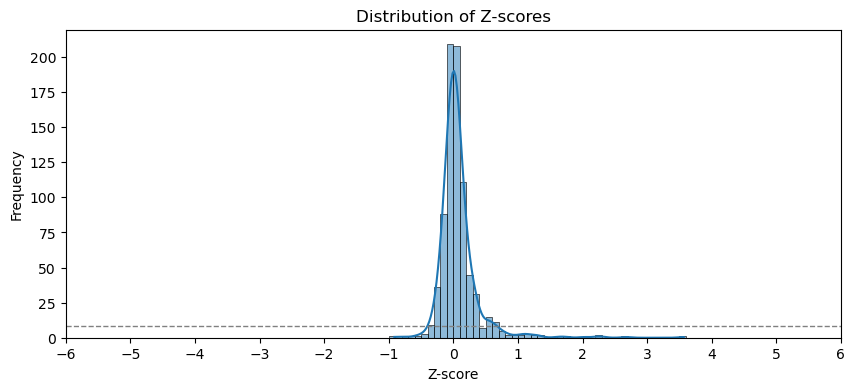

In [19]:
# Plotting the distribution of 'Z-score'
plt.figure(figsize=(10, 4))  # Adjust size as needed
sns.histplot(merged_df['Z-score'], kde=True, binwidth=0.1, binrange=(-6, 6))
plt.title('Distribution of Z-scores')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.xlim(-6, 6)  # Limiting the x-axis to focus from -6 to 6
plt.xticks(range(-6, 7))  # Setting x-axis ticks

# Draw a horizontal light dashed line at y=8
plt.axhline(y=8, color='gray', linestyle='--', linewidth=1)

# Save the plot to a file
plt.show()
# plt.savefig('ZScore_Histogram_Zoomed.png', dpi=300)  # dpi can be adjusted based on required resolution

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


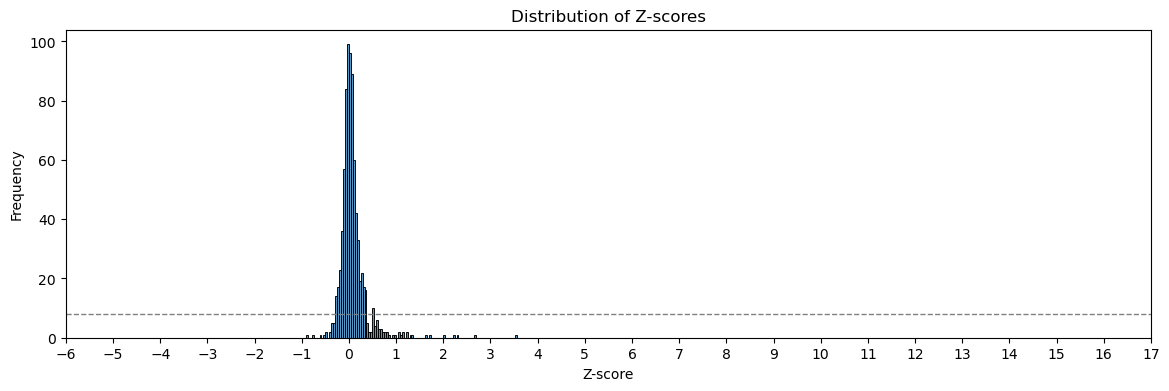

In [22]:
# Plotting the distribution of 'Z-score'
plt.figure(figsize=(14, 4))  # Adjust size as needed
sns.histplot(merged_df['Z-score'], kde=False)
plt.title('Distribution of Z-scores')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
# plt.xlim(-6, 6)  # Limiting the x-axis to focus from -6 to 6
plt.xticks(range(-6, 18))  # Setting x-axis ticks

# Draw a horizontal light dashed line at y=8
plt.axhline(y=8, color='gray', linestyle='--', linewidth=1)

# Save the plot to a file
plt.show()
# plt.savefig('ZScore_Histogram_Zoomed2.png', dpi=300)  # dpi can be adjusted based on required resolution

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


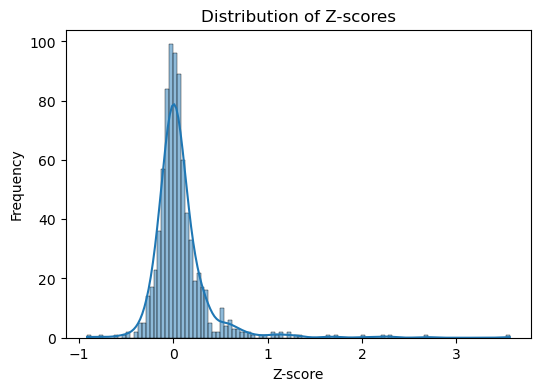

In [23]:
# Plotting the distribution of 'Z-score'
plt.figure(figsize=(6, 4))  # Adjust size as needed
sns.histplot(merged_df['Z-score'], kde=True)
plt.title('Distribution of Z-scores')
plt.xlabel('Z-score')
plt.ylabel('Frequency')

# Save the plot to a file
plt.show()
# plt.savefig('ZScore_Histogram.png', dpi=300)  # dpi can be adjusted based on required resolution

In [24]:
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

# Calculate 'Pre-event M' and 'Pre-event Std' for each row
pre_event_mean = event_spikes[pre_event_cols].mean(axis=1)
pre_event_std = event_spikes[pre_event_cols].std(axis=1).round(3)

# Normalize 'Event' columns based on 'Pre-event M' and 'Pre-event Std'
normalized_event_cols = event_spikes[event_cols].apply(lambda x: (x - pre_event_mean) / pre_event_std, axis=0)
normalized_event_cols = normalized_event_cols.replace([np.inf, -np.inf], np.nan)  # Handle division by zero by replacing infinities with NaN

# Calculate 'Event Z-Score' for each row
event_z_score = normalized_event_cols.mean(axis=1)

# Creating the final DataFrame with the calculated columns at the end
event_spikes_zscores_final = pd.concat([event_spikes, normalized_event_cols, pre_event_mean.rename('Pre-event M'), pre_event_std.rename('Pre-event Std'), event_z_score.rename('Event Z-Score')], axis=1)

event_spikes_zscores_final.dropna(inplace=True)

event_spikes_zscores_final

,Recording,Event name,Event number,Unit number,Pre-event spike 1,Pre-event spike 2,Pre-event spike 3,Pre-event spike 4,Pre-event spike 5,Pre-event spike 6,...,Event spike 94,Event spike 95,Event spike 96,Event spike 97,Event spike 98,Event spike 99,Event spike 100,Pre-event M,Pre-event Std,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,85,0,1,0,0,0,0,...,-0.364964,-0.364964,-0.364964,-0.364964,-0.364964,-0.364964,-0.364964,0.15,0.411,-7.299270e-02
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,85,0,0,0,0,0,0,...,-0.141844,-0.141844,-0.141844,-0.141844,-0.141844,-0.141844,-0.141844,0.02,0.141,-1.418440e-01
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,85,0,0,0,0,0,0,...,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,0.01,0.100,2.000000e-01
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,85,0,0,0,0,0,0,...,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,0.03,0.171,-5.847953e-02
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,85,0,0,0,0,0,0,...,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,-0.175439,0.03,0.171,-1.754386e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10004,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,5,11,0,0,0,0,0,0,...,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,0.01,0.100,5.000000e-01
10013,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,14,11,0,0,0,0,0,1,...,-0.419708,-0.419708,-0.419708,-0.419708,-0.419708,-0.419708,-0.419708,0.23,0.548,-3.832117e-01
10014,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,15,11,0,0,0,0,0,0,...,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,0.01,0.100,-4.718448e-18
10016,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0,0,0,0,0,0,...,-0.134529,-0.134529,-0.134529,-0.134529,-0.134529,-0.134529,-0.134529,0.03,0.223,-4.484305e-02


In [25]:
def custom_aggregate(z_scores):
    if len(z_scores) < 2:
        return '< 2 events'
    else:
        return z_scores.mean()

# Group by 'Recording', 'Event name', and 'Unit number', then apply the custom aggregation function
zscore_df = event_spikes_zscores_final.groupby(['Recording', 'Event name', 'Unit number'])['Event Z-Score'].apply(custom_aggregate).reset_index()

# Rename the column from the aggregation result to 'Z-score'
zscore_df.rename(columns={'Event Z-Score': 'Z-score'}, inplace=True)

zscore_df

,Recording,Event name,Unit number,Z-score
0,20230612_101430_standard_comp_to_training_D1_s...,lose,2,-0.024142
1,20230612_101430_standard_comp_to_training_D1_s...,lose,5,-0.117428
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,0.075553
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,0.033169
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,0.091453
...,...,...,...,...
797,20230625_112913_standard_comp_to_both_rewarded...,win,60,0.281825
798,20230625_112913_standard_comp_to_both_rewarded...,win,77,0.035138
799,20230625_112913_standard_comp_to_both_rewarded...,win,85,0.065548
800,20230625_112913_standard_comp_to_both_rewarded...,win,99,-0.049478


In [26]:
max_event_numbers = event_spikes_zscores_final.groupby(['Recording', 'Event name'])['Event number'].max().reset_index()
max_event_numbers.rename(columns={'Event number': 'Max Event number'}, inplace=True)

# Step 2: Merge this max event number data with the zscore_df
merged_df = pd.merge(zscore_df, max_event_numbers, on=['Recording', 'Event name'], how='left')

# Remove any NaN values that might affect correlation and regression analysis
merged_df.dropna(inplace=True)

# Coerce non-numeric 'Z-score' values to NaN
merged_df['Z-score'] = pd.to_numeric(merged_df['Z-score'], errors='coerce')

# Drop rows where 'Z-score' is NaN
merged_df = merged_df.dropna(subset=['Z-score'])

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


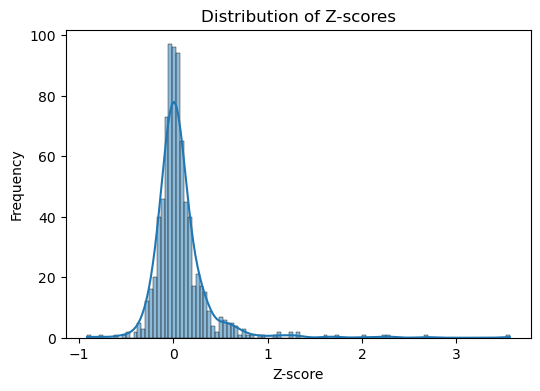

In [27]:
# Plotting the distribution of 'Z-score'
plt.figure(figsize=(6, 4))  # Adjust size as needed
sns.histplot(merged_df['Z-score'], kde=True)
plt.title('Distribution of Z-scores')
plt.xlabel('Z-score')
plt.ylabel('Frequency')

# Save the plot to a file
plt.show()
# plt.savefig('ZScore_Histogram.png', dpi=300)  # dpi can be adjusted based on required resolution

In [28]:
# Printing unique values from the 'Event name' column
unique_event_names = event_spikes_zscores_final['Event name'].unique()
print("Unique Event Names:", unique_event_names)

Unique Event Names: ['rewarded' 'win' 'lose' 'omission' 'both_rewarded']


In [29]:
rewarded_zscores = event_spikes_zscores_final[event_spikes_zscores_final['Event name']=='rewarded']
win_zscores = event_spikes_zscores_final[event_spikes_zscores_final['Event name']=='win']
lose_zscores = event_spikes_zscores_final[event_spikes_zscores_final['Event name']=='lose']
omission_zscores = event_spikes_zscores_final[event_spikes_zscores_final['Event name']=='omission']
both_rewarded_zscores = event_spikes_zscores_final[event_spikes_zscores_final['Event name']=='both_rewarded']

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Event Z-Score', ylabel='Count'>

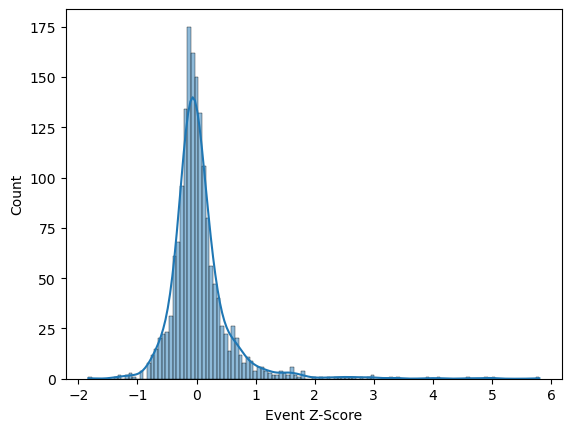

In [30]:
sns.histplot(rewarded_zscores['Event Z-Score'], kde=True)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Event Z-Score', ylabel='Count'>

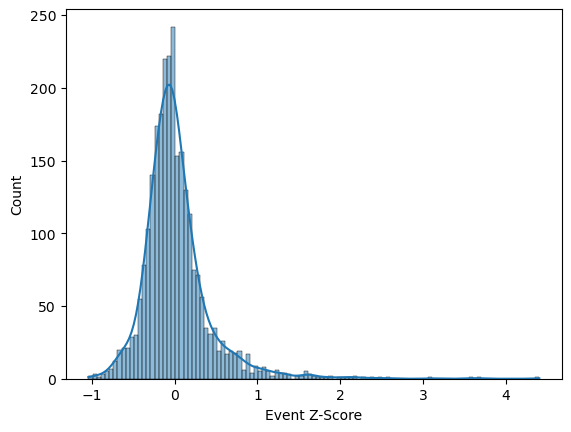

In [31]:
sns.histplot(win_zscores['Event Z-Score'], kde=True)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Event Z-Score', ylabel='Count'>

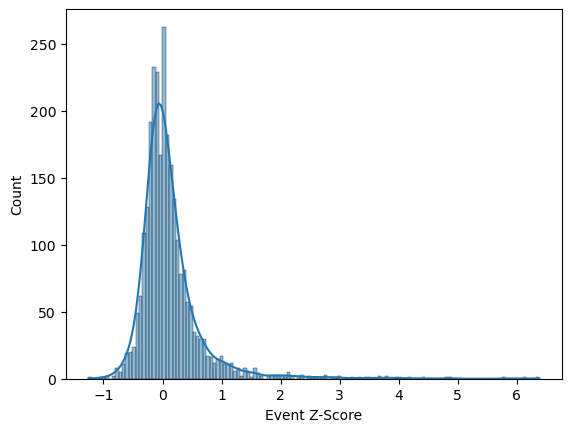

In [32]:
sns.histplot(lose_zscores['Event Z-Score'], kde=True)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Event Z-Score', ylabel='Count'>

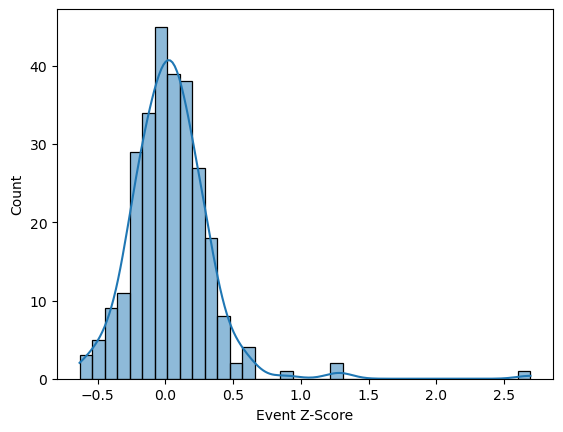

In [33]:
sns.histplot(omission_zscores['Event Z-Score'], kde=True)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Event Z-Score', ylabel='Count'>

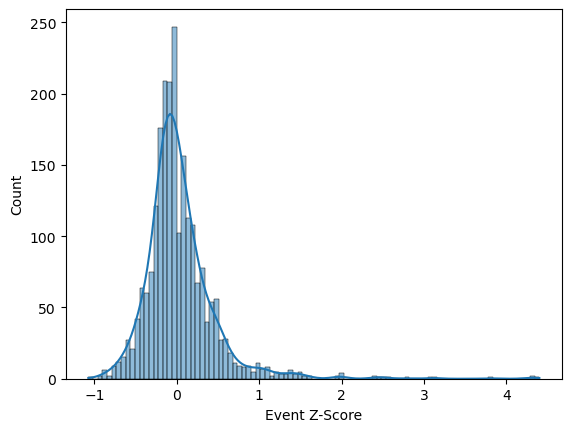

In [34]:
sns.histplot(both_rewarded_zscores['Event Z-Score'], kde=True)

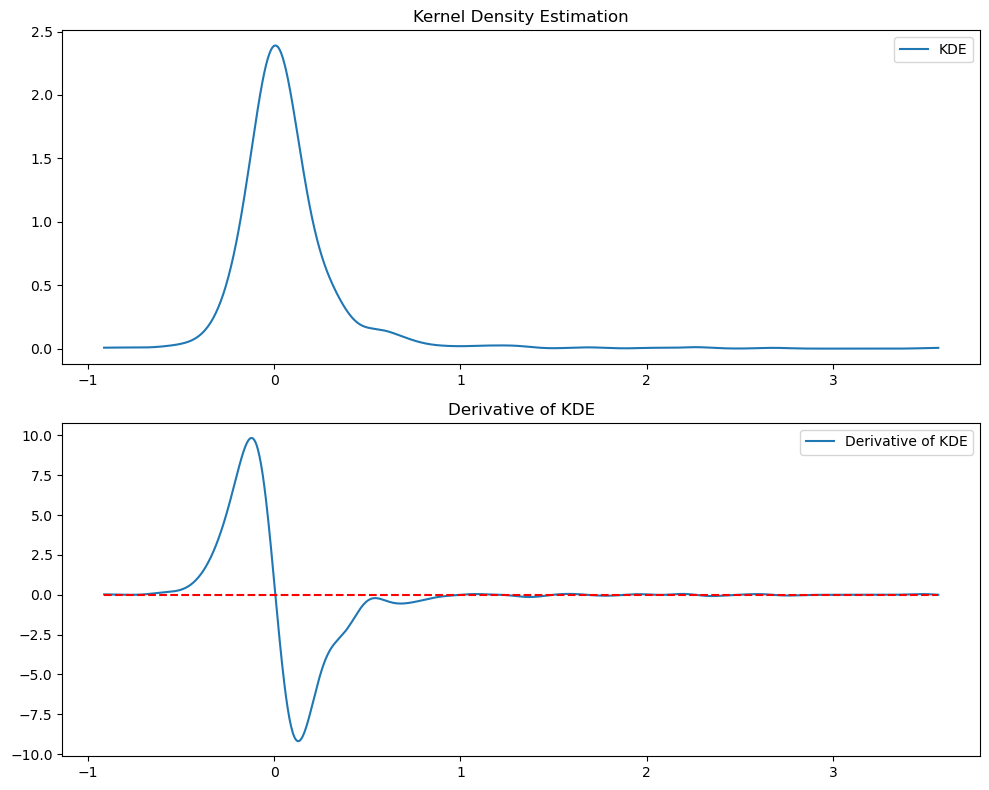

Potential Cutoff Points: [-0.80190639 -0.7570617   0.005298    0.99636561  1.21610459  1.49414165
  1.67800488  1.87980597  2.04573132  2.09954494  2.25650135  2.48520926
  2.67355695  3.11751937]
Local Minima: [-0.7570617   1.00085008  1.49862612  1.88429044  2.09954494  2.48969373
  3.12200384]
Local Maxima: [-0.80190639  0.005298    1.22058905  1.67800488  2.04573132  2.26098582
  2.67804142]


In [35]:
# Calculate KDE
kde = gaussian_kde(merged_df['Z-score'])
x = np.linspace(min(merged_df['Z-score']), max(merged_df['Z-score']), 1000)
kde_values = kde(x)

# Calculate the derivative of KDE
kde_derivative = np.gradient(kde_values, x)

# Plot KDE and its derivative
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(x, kde_values, label='KDE')
ax[0].set_title('Kernel Density Estimation')
ax[0].legend()

ax[1].plot(x, kde_derivative, label='Derivative of KDE')
ax[1].set_title('Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')  # Zero line for reference
ax[1].legend()

plt.tight_layout()
plt.show()

# Finding inflection points: points where the derivative changes sign
inflection_points = x[np.where(np.diff(np.sign(kde_derivative)))[0]]
print("Potential Cutoff Points:", inflection_points)

# Additionally, you might want to identify local minima or maxima if they are relevant
minima = x[argrelextrema(kde_values, np.less)[0]]
maxima = x[argrelextrema(kde_values, np.greater)[0]]
print("Local Minima:", minima)
print("Local Maxima:", maxima)

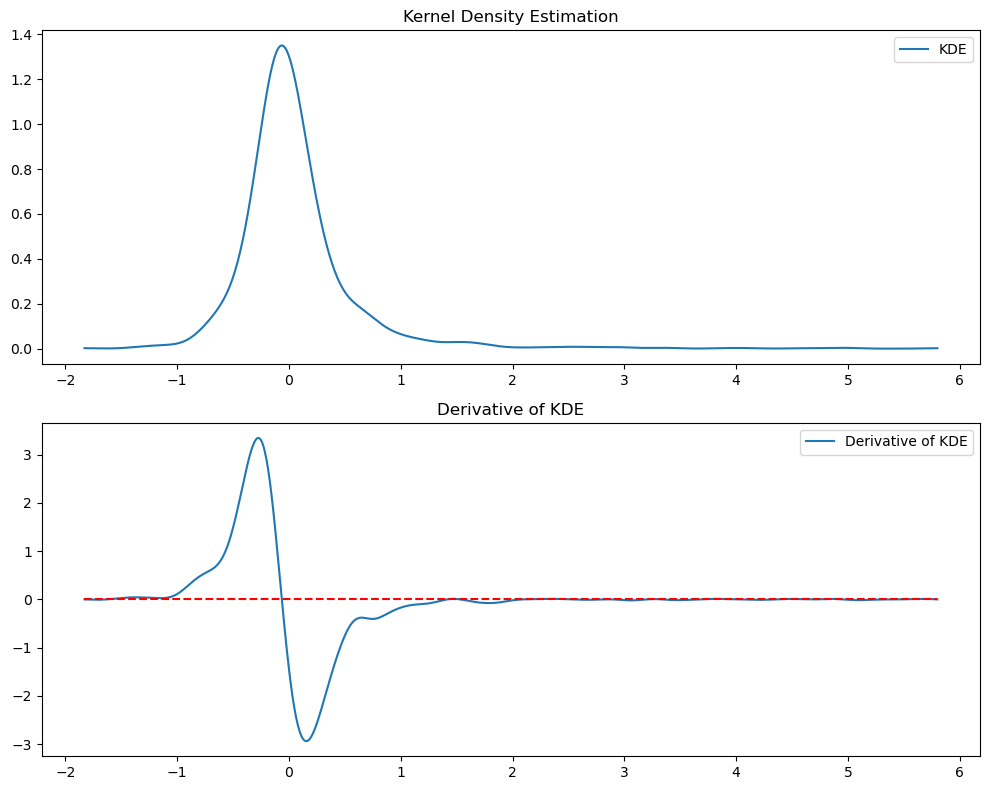

Potential Cutoff Points: [-1.63032765 -0.06484238  1.40900473  1.53118894  2.08865443  2.53157221
  2.81412321  2.88285184  3.19594889  3.33340613  3.6541397   3.99778281
  4.34906243  4.63161343  4.70034205  4.94471049  5.39526478]
Local Minima: [-1.63032765  1.41664124  2.09629094  2.82175973  3.2035854   3.6541397
  4.34906243  4.70034205  5.4029013 ]
Local Maxima: [-0.06484238  1.53118894  2.53920873  2.89048835  3.34104265  3.99778281
  4.63161343  4.94471049]


In [36]:
# Calculate KDE
kde = gaussian_kde(rewarded_zscores['Event Z-Score'])
x = np.linspace(min(rewarded_zscores['Event Z-Score']), max(rewarded_zscores['Event Z-Score']), 1000)
kde_values = kde(x)

# Calculate the derivative of KDE
kde_derivative = np.gradient(kde_values, x)

# Plot KDE and its derivative
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(x, kde_values, label='KDE')
ax[0].set_title('Kernel Density Estimation')
ax[0].legend()

ax[1].plot(x, kde_derivative, label='Derivative of KDE')
ax[1].set_title('Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')  # Zero line for reference
ax[1].legend()

plt.tight_layout()
plt.show()

# Finding inflection points: points where the derivative changes sign
inflection_points = x[np.where(np.diff(np.sign(kde_derivative)))[0]]
print("Potential Cutoff Points:", inflection_points)

# Additionally, you might want to identify local minima or maxima if they are relevant
minima = x[argrelextrema(kde_values, np.less)[0]]
maxima = x[argrelextrema(kde_values, np.greater)[0]]
print("Local Minima:", minima)
print("Local Maxima:", maxima)

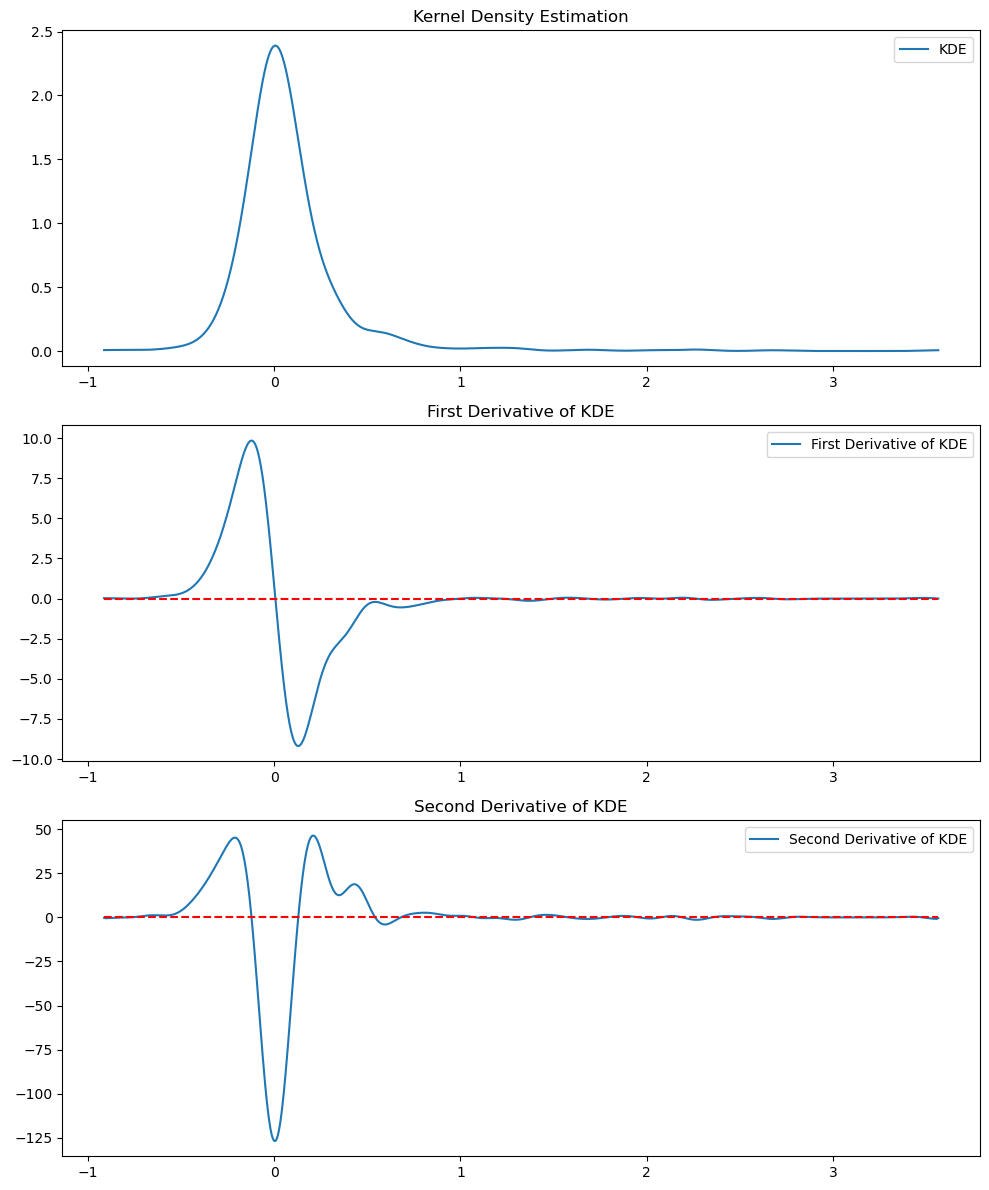

Local Minima: [-0.7570617   1.00085008  1.49862612  1.88429044  2.09954494  2.48969373
  3.12200384]
Local Maxima: [-0.80190639  0.005298    1.22058905  1.67800488  2.04573132  2.26098582
  2.67804142]
Local minima of first derivative: [-0.77499957  0.13086313  0.67796833  1.36857653  1.78114766  2.07263813
  2.3506752   2.75876186]
Local maxima of first derivative: [-0.12026712  0.54343426  1.08157052  1.57934656  1.96052641  2.19371879
  2.59283652  3.48076134]
Significant slope change points: [-0.64494998 -0.2099565   0.2070991   0.43132254  0.80801792  0.99636561
  1.18022884  1.4582659   1.87083703  2.1354207   2.42691117  2.82154443
  3.42246325]


In [37]:
# Calculate KDE and its derivatives
kde = gaussian_kde(merged_df['Z-score'])
x = np.linspace(min(merged_df['Z-score']), max(merged_df['Z-score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local extrema of the first derivative
local_minima_deriv = x[argrelextrema(kde_derivative, np.less)[0]]
local_maxima_deriv = x[argrelextrema(kde_derivative, np.greater)[0]]

# Plot the KDE, its first derivative, and its second derivative
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].plot(x, kde_values, label='KDE')
ax[0].set_title('Kernel Density Estimation')
ax[0].legend()

ax[1].plot(x, kde_derivative, label='First Derivative of KDE')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].legend()

ax[2].plot(x, kde_second_derivative, label='Second Derivative of KDE')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].legend()

plt.tight_layout()
plt.show()

# Identify local minima or maxima if they are relevant
minima = x[argrelextrema(kde_values, np.less)[0]]
maxima = x[argrelextrema(kde_values, np.greater)[0]]
print("Local Minima:", minima)
print("Local Maxima:", maxima)

# Output local extrema points from the first derivative
print("Local minima of first derivative:", local_minima_deriv)
print("Local maxima of first derivative:", local_maxima_deriv)

# To find the most significant slope changes, look for extrema in the second derivative
significant_slope_changes = x[argrelextrema(kde_second_derivative, np.greater)[0]]
print("Significant slope change points:", significant_slope_changes)

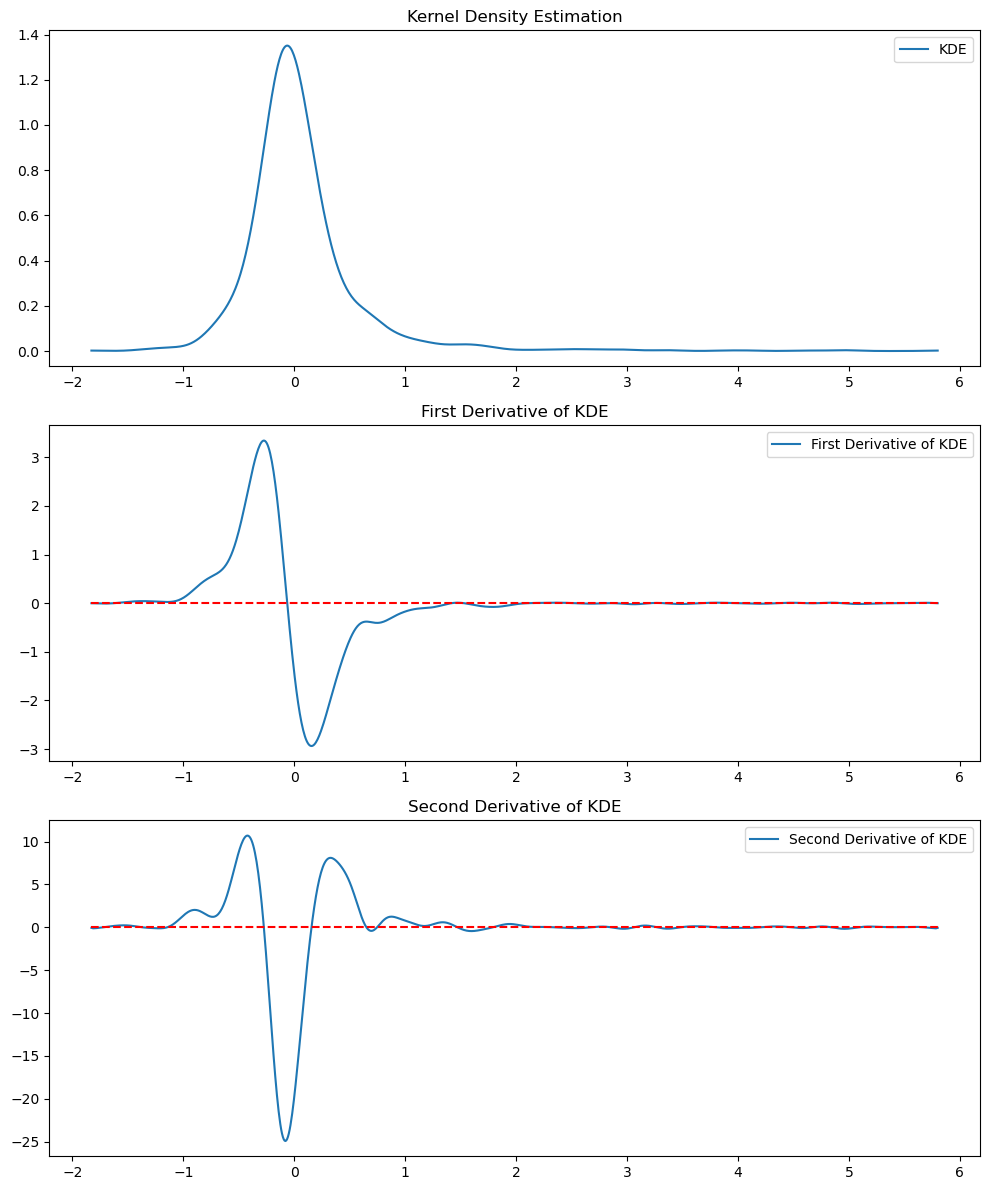

Local Minima: [-1.63032765  1.41664124  2.09629094  2.82175973  3.2035854   3.6541397
  4.34906243  4.70034205  5.4029013 ]
Local Maxima: [-0.06484238  1.53118894  2.53920873  2.89048835  3.34104265  3.99778281
  4.63161343  4.94471049]
Local minima of first derivative: [-1.72196582 -1.1492273   0.15661651  0.74462805  1.7908304   2.67666597
  3.05849165  3.4861364   4.19633216  4.669796    5.08980424]
Local maxima of first derivative: [-1.37068619 -0.27102825  0.65298989  1.47009683  2.34829589  2.8599423
  3.26467751  3.80686997  4.48651967  4.8377993   5.67781578]
Significant slope change points of first derivative: [-1.37068619 -0.27102825  0.65298989  1.47009683  2.34829589  2.8599423
  3.26467751  3.80686997  4.48651967  4.8377993   5.67781578]
Significant slope change points of second derivative: [-1.53868949 -0.89722236 -0.42375852  0.32461981  0.87444878  1.3402761
  1.94356067  2.23374819  2.77594065  3.16540284  3.62359365  3.99778281
  4.34142592  4.76143416  5.18907892  5.

In [38]:
# Calculate KDE and its derivatives
kde = gaussian_kde(rewarded_zscores['Event Z-Score'])
x = np.linspace(min(rewarded_zscores['Event Z-Score']), max(rewarded_zscores['Event Z-Score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local extrema of the first derivative
local_minima_deriv = x[argrelextrema(kde_derivative, np.less)[0]]
local_maxima_deriv = x[argrelextrema(kde_derivative, np.greater)[0]]

# Plot the KDE, its first derivative, and its second derivative
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].plot(x, kde_values, label='KDE')
ax[0].set_title('Kernel Density Estimation')
ax[0].legend()

ax[1].plot(x, kde_derivative, label='First Derivative of KDE')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].legend()

ax[2].plot(x, kde_second_derivative, label='Second Derivative of KDE')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].legend()

plt.tight_layout()
plt.show()

# Identify local minima or maxima if they are relevant
minima = x[argrelextrema(kde_values, np.less)[0]]
maxima = x[argrelextrema(kde_values, np.greater)[0]]
print("Local Minima:", minima)
print("Local Maxima:", maxima)

# Output local extrema points from the first derivative
print("Local minima of first derivative:", local_minima_deriv)
print("Local maxima of first derivative:", local_maxima_deriv)

# To find the most significant slope changes, look for extrema in the second derivative
significant_slope_changes = x[argrelextrema(kde_derivative, np.greater)[0]]
print("Significant slope change points of first derivative:", significant_slope_changes)

# To find the most significant slope changes, look for extrema in the second derivative
significant_slope_changes = x[argrelextrema(kde_second_derivative, np.greater)[0]]
print("Significant slope change points of second derivative:", significant_slope_changes)

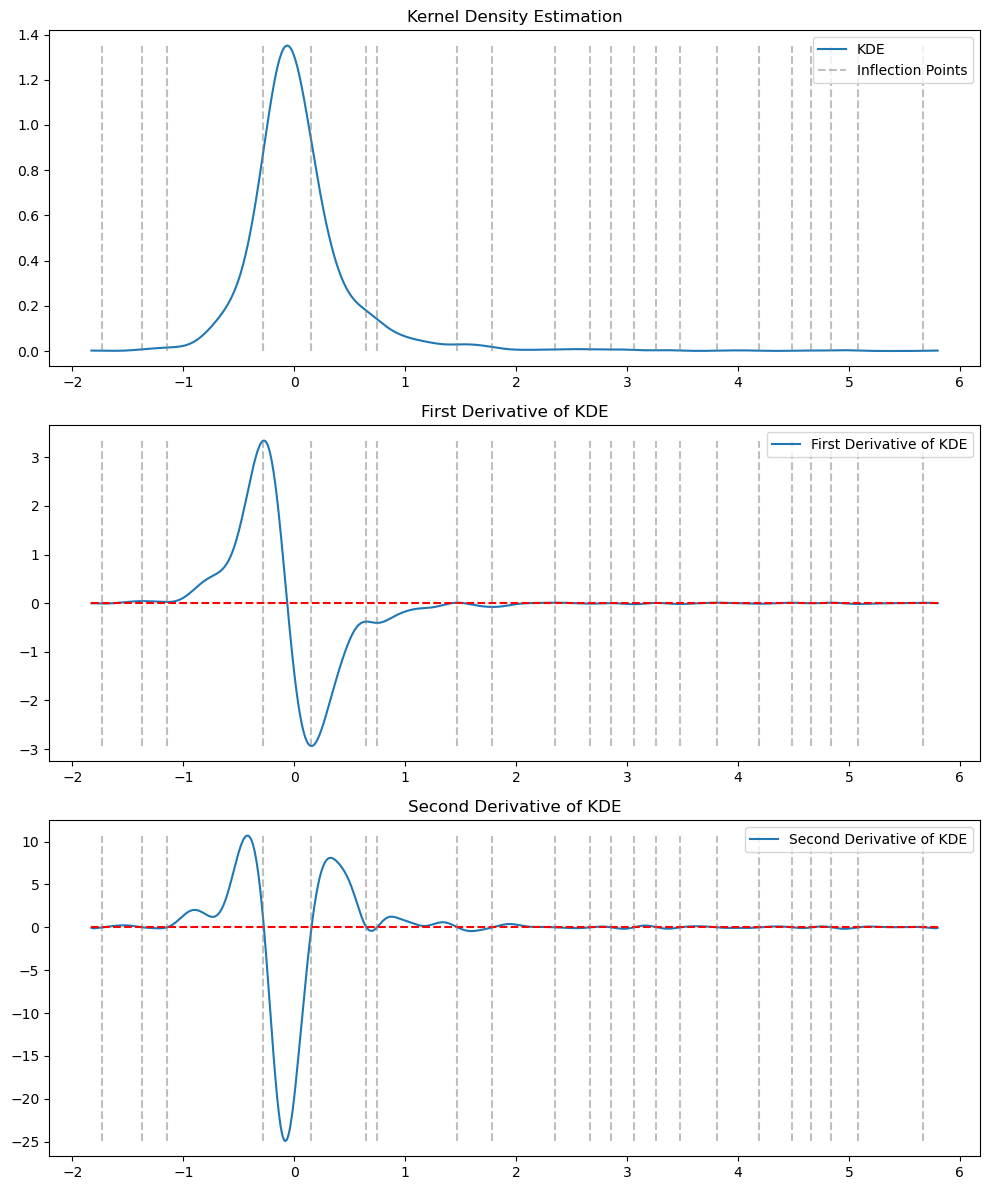

Inflection points from second derivative: [-1.72960233 -1.37068619 -1.1492273  -0.27866476  0.14898     0.64535337
  0.74462805  1.47009683  1.78319389  2.34829589  2.66902946  2.85230578
  3.05849165  3.26467751  3.47849989  3.80686997  4.18869565  4.48651967
  4.66215949  4.8377993   5.08216773  5.67017927]


In [39]:
# Find zeros of the second derivative
inflection_points_second_derivative = x[np.where(np.diff(np.sign(kde_second_derivative)))[0]]

# Plot the KDE, its first derivative, and its second derivative with inflection points
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot KDE
ax[0].plot(x, kde_values, label='KDE')
ax[0].set_title('Kernel Density Estimation')
ax[0].vlines(inflection_points_second_derivative, ymin=min(kde_values), ymax=max(kde_values), color='grey', linestyle='--', alpha=0.5, label='Inflection Points')
ax[0].legend()

# Plot first derivative of KDE
ax[1].plot(x, kde_derivative, label='First Derivative of KDE')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].vlines(inflection_points_second_derivative, ymin=min(kde_derivative), ymax=max(kde_derivative), color='grey', linestyle='--', alpha=0.5)
ax[1].legend()

# Plot second derivative of KDE
ax[2].plot(x, kde_second_derivative, label='Second Derivative of KDE')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].vlines(inflection_points_second_derivative, ymin=min(kde_second_derivative), ymax=max(kde_second_derivative), color='grey', linestyle='--', alpha=0.5)
ax[2].legend()

plt.tight_layout()
plt.show()

# Print the inflection points from the second derivative
print("Inflection points from second derivative:", inflection_points_second_derivative)

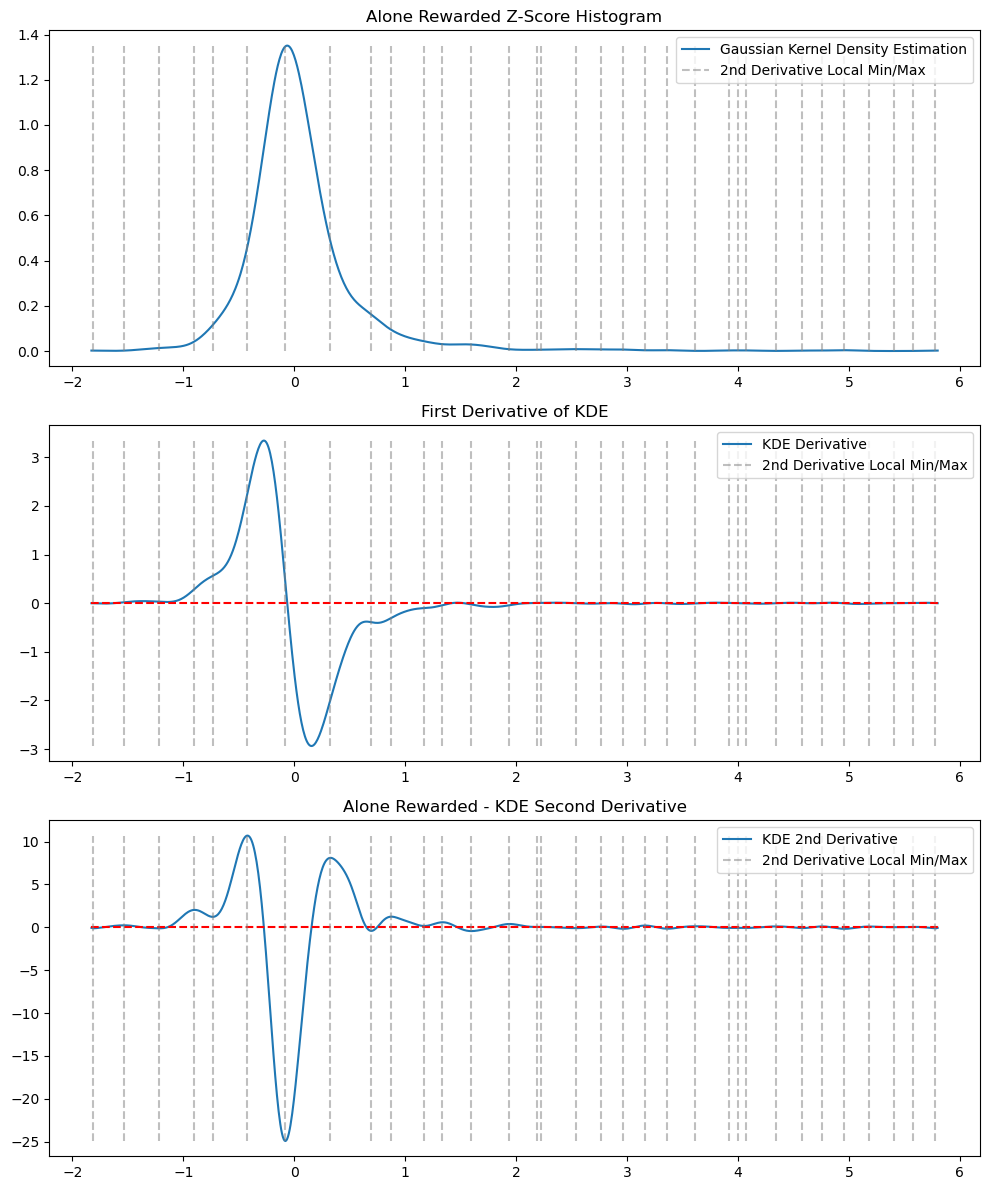

Local minima and maxima from second derivative: [-1.81360398 -1.53868949 -1.21795592 -0.90485887 -0.73685557 -0.42375852
 -0.08775192  0.32461981  0.69117246  0.87444878  1.17227281  1.33263959
  1.59228105  1.93592416  2.18792911  2.22611167  2.53920873  2.76830413
  2.96685348  3.15776632  3.36395219  3.61595713  3.92141767  3.99778281
  4.07414794  4.34142592  4.57815784  4.75379765  4.952347    5.1814424
  5.4029013   5.57854111  5.77709046]


In [40]:
# Calculate KDE and its derivatives
kde = gaussian_kde(rewarded_zscores['Event Z-Score'])
x = np.linspace(min(rewarded_zscores['Event Z-Score']), max(rewarded_zscores['Event Z-Score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local minima and maxima of the second derivative
second_derivative_sign_changes = np.diff(np.sign(np.gradient(kde_second_derivative, x)))
local_minima_maxima = x[:-1][np.where(second_derivative_sign_changes != 0)[0]]

# Plot the KDE, its first derivative, and its second derivative with local minima and maxima marked
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot KDE
ax[0].plot(x, kde_values, label='Gaussian Kernel Density Estimation')
ax[0].set_title('Alone Rewarded Z-Score Histogram')
ax[0].vlines(local_minima_maxima, ymin=min(kde_values), ymax=max(kde_values), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[0].legend()

# Plot first derivative of KDE
ax[1].plot(x, kde_derivative, label='KDE Derivative')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].vlines(local_minima_maxima, ymin=min(kde_derivative), ymax=max(kde_derivative), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[1].legend()

# Plot second derivative of KDE
ax[2].plot(x, kde_second_derivative, label='KDE 2nd Derivative')
ax[2].set_title('Alone Rewarded - KDE Second Derivative')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].vlines(local_minima_maxima, ymin=min(kde_second_derivative), ymax=max(kde_second_derivative), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[2].legend()

plt.tight_layout()
plt.show()
# plt.savefig('ZScore_Histogram.png', dpi=300)  # dpi can be adjusted based on required resolution

# Print the local minima and maxima points from the second derivative
print("Local minima and maxima from second derivative:", local_minima_maxima)

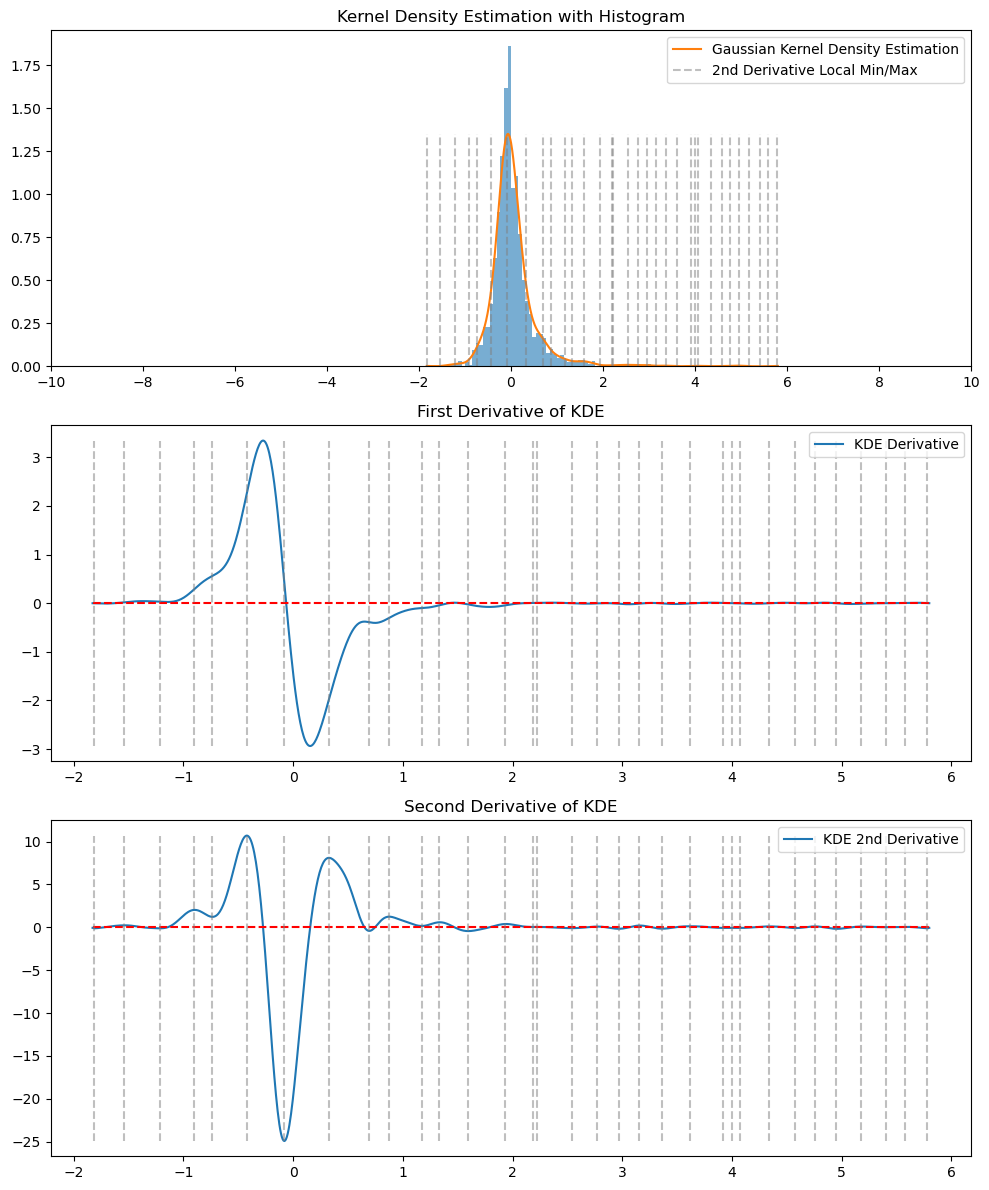

Local minima and maxima from second derivative: [-1.81360398 -1.53868949 -1.21795592 -0.90485887 -0.73685557 -0.42375852
 -0.08775192  0.32461981  0.69117246  0.87444878  1.17227281  1.33263959
  1.59228105  1.93592416  2.18792911  2.22611167  2.53920873  2.76830413
  2.96685348  3.15776632  3.36395219  3.61595713  3.92141767  3.99778281
  4.07414794  4.34142592  4.57815784  4.75379765  4.952347    5.1814424
  5.4029013   5.57854111  5.77709046]


In [41]:
# Calculate KDE and its derivatives
kde = gaussian_kde(rewarded_zscores['Event Z-Score'])
x = np.linspace(min(rewarded_zscores['Event Z-Score']), max(rewarded_zscores['Event Z-Score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local minima and maxima of the second derivative
second_derivative_sign_changes = np.diff(np.sign(np.gradient(kde_second_derivative, x)))
local_minima_maxima = x[:-1][np.where(second_derivative_sign_changes != 0)[0]]

# Plot the KDE, its first derivative, and its second derivative with local minima and maxima marked
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot KDE and histogram
ax[0].hist(rewarded_zscores['Event Z-Score'], bins=100, alpha=0.6, density=True)
ax[0].plot(x, kde_values, label='Gaussian Kernel Density Estimation')
ax[0].set_title('Kernel Density Estimation with Histogram')
ax[0].vlines(local_minima_maxima, ymin=min(kde_values), ymax=max(kde_values), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[0].legend()

# Adjust x-axis to only include even numbers from -10 to +10
ax[0].set_xticks(np.arange(-10, 11, 2))  # This range might need adjustment based on the actual data range

# Plot first derivative of KDE
ax[1].plot(x, kde_derivative, label='KDE Derivative')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].vlines(local_minima_maxima, ymin=min(kde_derivative), ymax=max(kde_derivative), color='grey', linestyle='--', alpha=0.5)
ax[1].legend()

# Plot second derivative of KDE
ax[2].plot(x, kde_second_derivative, label='KDE 2nd Derivative')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].vlines(local_minima_maxima, ymin=min(kde_second_derivative), ymax=max(kde_second_derivative), color='grey', linestyle='--', alpha=0.5)
ax[2].legend()

plt.tight_layout()
plt.show()

# Print the local minima and maxima points from the second derivative
print("Local minima and maxima from second derivative:", local_minima_maxima)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


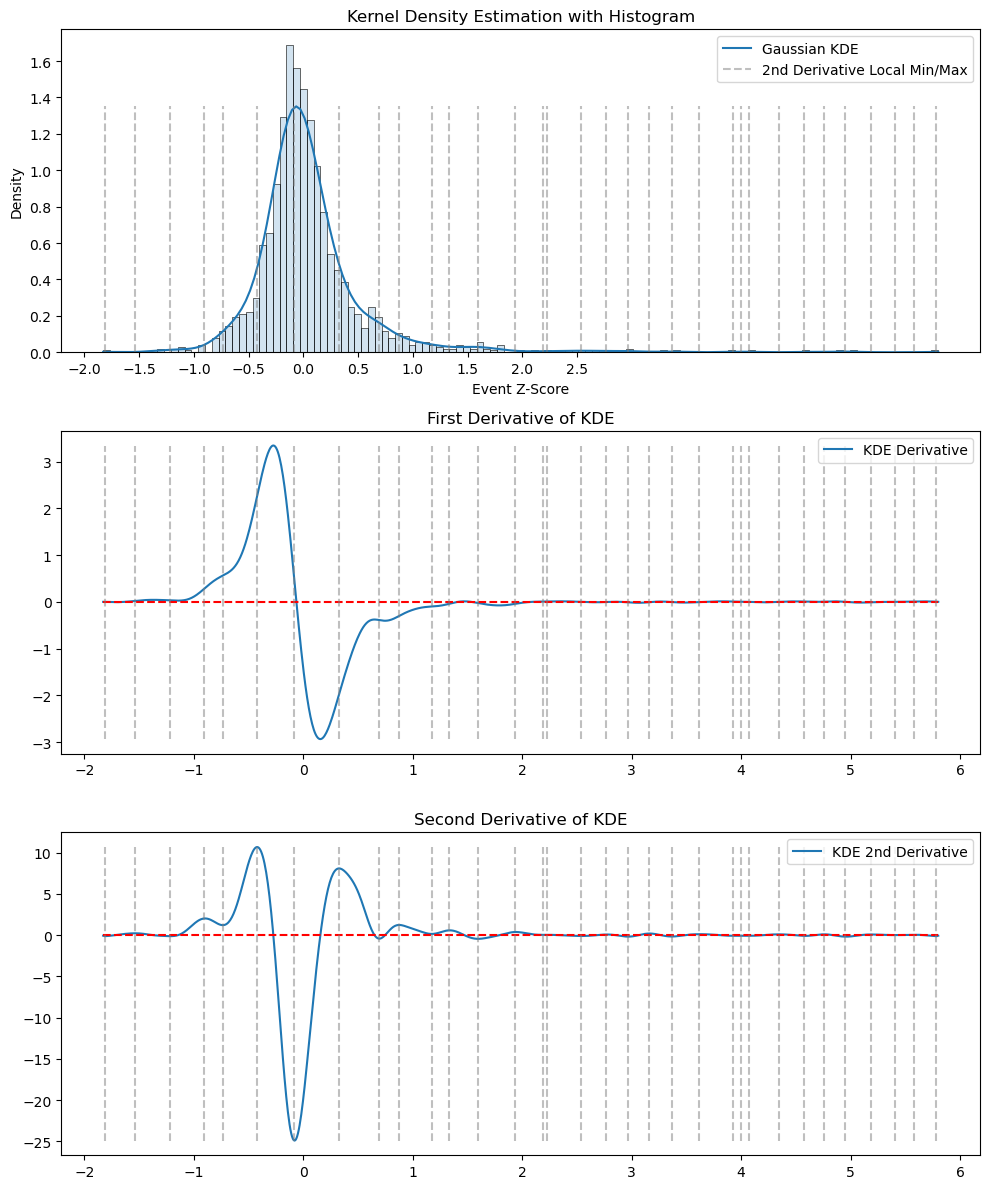

Local minima and maxima from second derivative: [-1.81360398 -1.53868949 -1.21795592 -0.90485887 -0.73685557 -0.42375852
 -0.08775192  0.32461981  0.69117246  0.87444878  1.17227281  1.33263959
  1.59228105  1.93592416  2.18792911  2.22611167  2.53920873  2.76830413
  2.96685348  3.15776632  3.36395219  3.61595713  3.92141767  3.99778281
  4.07414794  4.34142592  4.57815784  4.75379765  4.952347    5.1814424
  5.4029013   5.57854111  5.77709046]


In [48]:
# Calculate KDE and its derivatives
kde = gaussian_kde(rewarded_zscores['Event Z-Score'])
x = np.linspace(min(rewarded_zscores['Event Z-Score']), max(rewarded_zscores['Event Z-Score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local minima and maxima of the second derivative
second_derivative_sign_changes = np.diff(np.sign(np.gradient(kde_second_derivative, x)))
local_minima_maxima = x[:-1][np.where(second_derivative_sign_changes != 0)[0]]

# Plot the KDE, its first derivative, and its second derivative with local minima and maxima marked
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot KDE with histogram using sns.histplot
sns.histplot(rewarded_zscores['Event Z-Score'], kde=True, ax=ax[0], stat='density', alpha=0.2, line_kws={'label':'Gaussian KDE','color':'orange'})
ax[0].set_title('Kernel Density Estimation with Histogram')
ax[0].vlines(local_minima_maxima, ymin=0, ymax=max(kde_values), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[0].legend()

# Adjust x-axis ticks
custom_xticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]
ax[0].set_xticks(custom_xticks)

# Plot first derivative of KDE
ax[1].plot(x, kde_derivative, label='KDE Derivative')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].vlines(local_minima_maxima, ymin=min(kde_derivative), ymax=max(kde_derivative), color='grey', linestyle='--', alpha=0.5)
ax[1].legend()

# Plot second derivative of KDE
ax[2].plot(x, kde_second_derivative, label='KDE 2nd Derivative')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].vlines(local_minima_maxima, ymin=min(kde_second_derivative), ymax=max(kde_second_derivative), color='grey', linestyle='--', alpha=0.5)
ax[2].legend()

plt.tight_layout()
plt.show()

# Print the local minima and maxima points from the second derivative
print("Local minima and maxima from second derivative:", local_minima_maxima)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


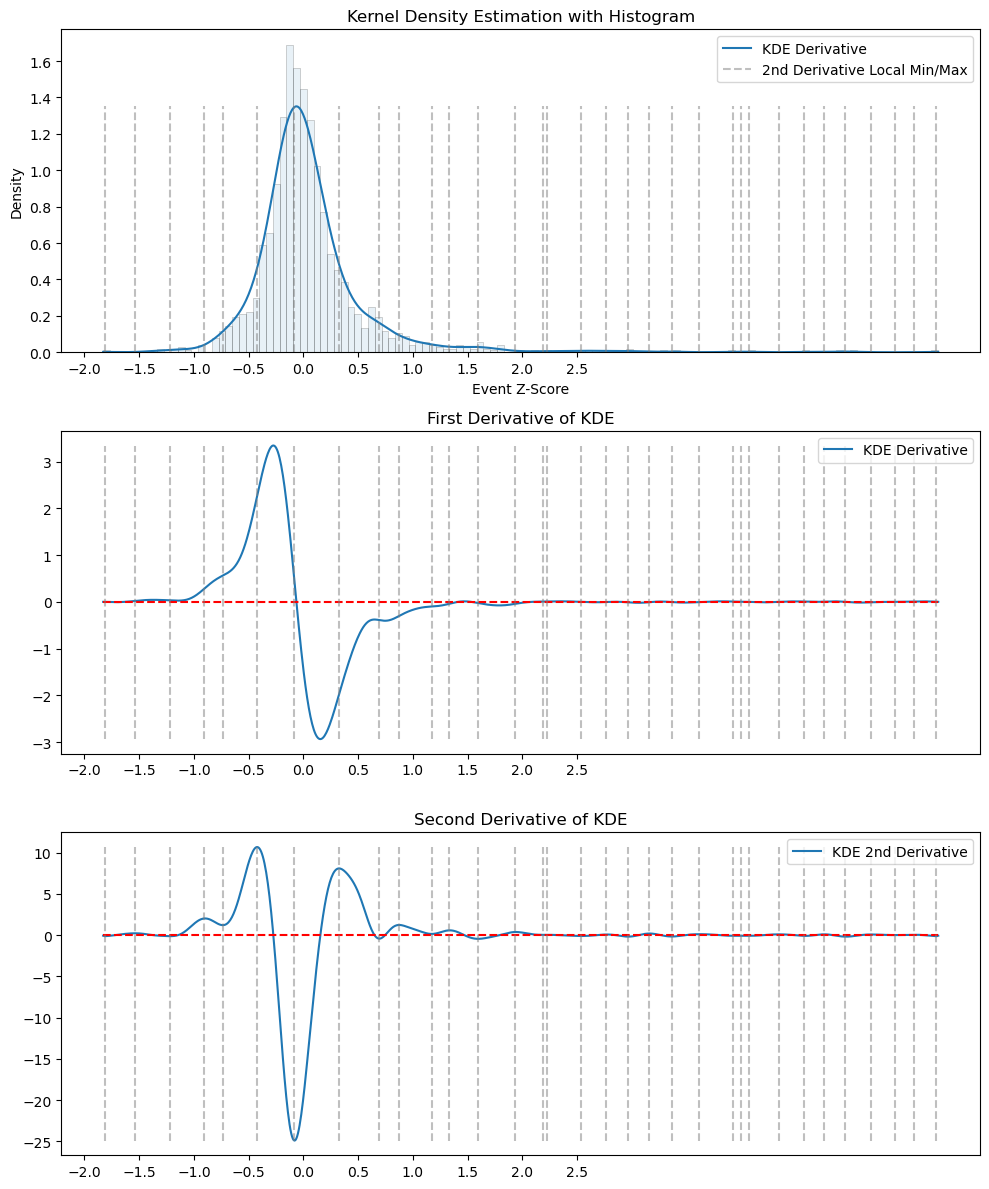

Local minima and maxima from second derivative: [-1.81360398 -1.53868949 -1.21795592 -0.90485887 -0.73685557 -0.42375852
 -0.08775192  0.32461981  0.69117246  0.87444878  1.17227281  1.33263959
  1.59228105  1.93592416  2.18792911  2.22611167  2.53920873  2.76830413
  2.96685348  3.15776632  3.36395219  3.61595713  3.92141767  3.99778281
  4.07414794  4.34142592  4.57815784  4.75379765  4.952347    5.1814424
  5.4029013   5.57854111  5.77709046]


In [47]:
# Calculate KDE and its derivatives
kde = gaussian_kde(rewarded_zscores['Event Z-Score'])
x = np.linspace(min(rewarded_zscores['Event Z-Score']), max(rewarded_zscores['Event Z-Score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local minima and maxima of the second derivative
second_derivative_sign_changes = np.diff(np.sign(np.gradient(kde_second_derivative, x)))
local_minima_maxima = x[:-1][np.where(second_derivative_sign_changes != 0)[0]]

# Plot the KDE, its first derivative, and its second derivative with local minima and maxima marked
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot KDE with histogram using sns.histplot
ax[0] = sns.histplot(rewarded_zscores['Event Z-Score'], ax=ax[0], stat='density', alpha=0.1, edgecolor=(0, 0, 0, 0.3))
ax[0].plot(x, kde_values, label='KDE Derivative')
ax[0].set_title('Kernel Density Estimation with Histogram')
ax[0].vlines(local_minima_maxima, ymin=0, ymax=max(kde_values), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[0].legend()

# Adjust x-axis ticks
custom_xticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]
ax[0].set_xticks(custom_xticks)

# Plot first derivative of KDE
ax[1].plot(x, kde_derivative, label='KDE Derivative')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].vlines(local_minima_maxima, ymin=min(kde_derivative), ymax=max(kde_derivative), color='grey', linestyle='--', alpha=0.5)
ax[1].legend()
ax[1].set_xticks(custom_xticks)

# Plot second derivative of KDE
ax[2].plot(x, kde_second_derivative, label='KDE 2nd Derivative')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].vlines(local_minima_maxima, ymin=min(kde_second_derivative), ymax=max(kde_second_derivative), color='grey', linestyle='--', alpha=0.5)
ax[2].legend()
ax[2].set_xticks(custom_xticks)

plt.tight_layout()
plt.show()

# Print the local minima and maxima points from the second derivative
print("Local minima and maxima from second derivative:", local_minima_maxima)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


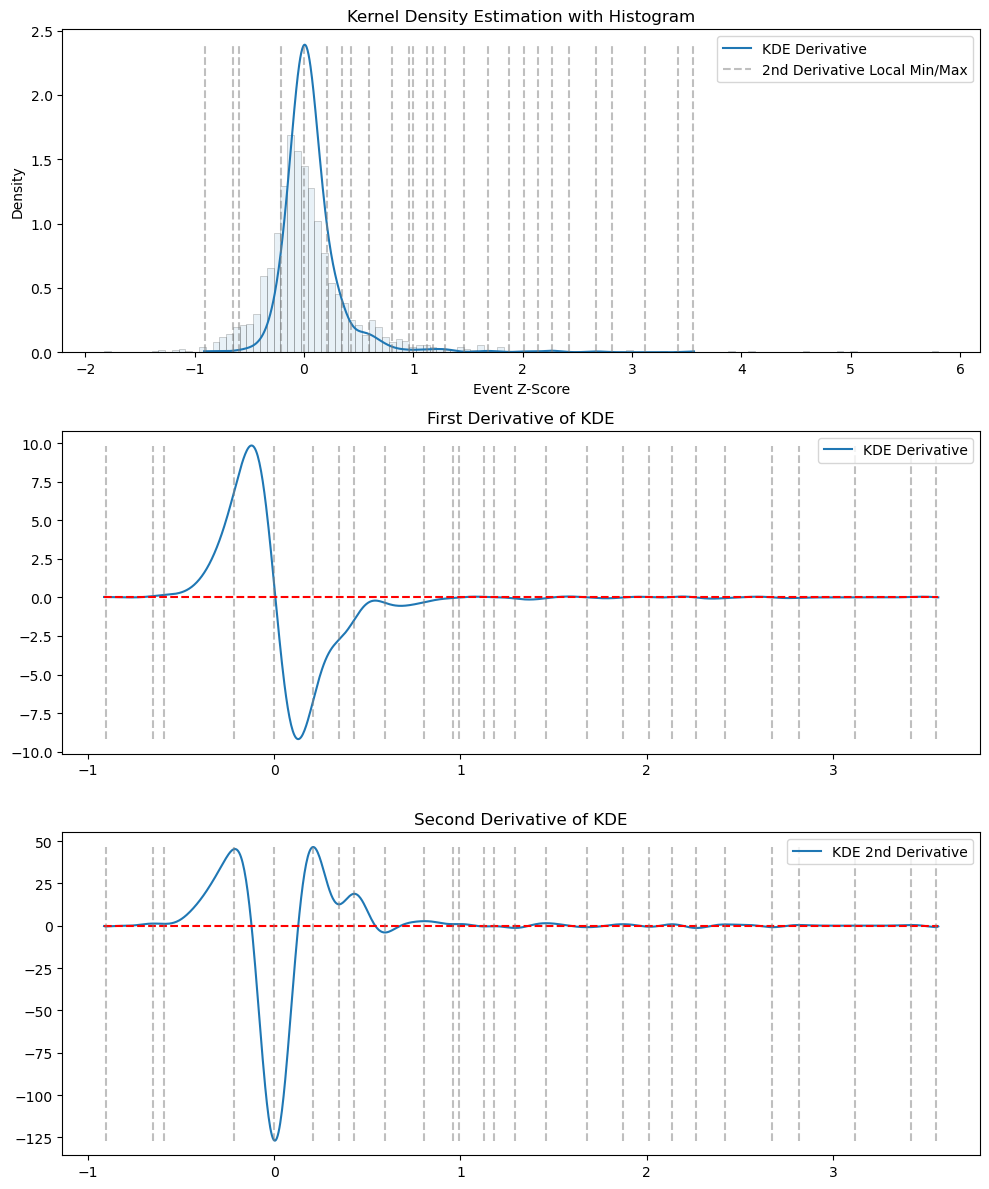

Local minima and maxima from second derivative: [-9.05049169e-01 -6.49434446e-01 -5.91136351e-01 -2.14440970e-01
  8.13533973e-04  2.07099100e-01  3.46117634e-01  4.26838073e-01
  5.92763419e-01  8.03533454e-01  9.60489863e-01  9.91881145e-01
  1.12641521e+00  1.18022884e+00  1.29234056e+00  1.45826590e+00
  1.67800488e+00  1.87083703e+00  2.01434004e+00  2.13542070e+00
  2.26547029e+00  2.42242670e+00  2.67355695e+00  2.81705996e+00
  3.11751937e+00  3.41797878e+00  3.55251284e+00]


In [44]:
# Calculate KDE and its derivatives
kde = gaussian_kde(merged_df['Z-score'])
x = np.linspace(min(merged_df['Z-score']), max(merged_df['Z-score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local minima and maxima of the second derivative
second_derivative_sign_changes = np.diff(np.sign(np.gradient(kde_second_derivative, x)))
local_minima_maxima = x[:-1][np.where(second_derivative_sign_changes != 0)[0]]

# Plot the KDE, its first derivative, and its second derivative with local minima and maxima marked
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot KDE with histogram using sns.histplot
ax[0] = sns.histplot(rewarded_zscores['Event Z-Score'], ax=ax[0], stat='density', alpha=0.1, edgecolor=(0, 0, 0, 0.3))
ax[0].plot(x, kde_values, label='KDE Derivative')
ax[0].set_title('Kernel Density Estimation with Histogram')
ax[0].vlines(local_minima_maxima, ymin=0, ymax=max(kde_values), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[0].legend()


# Plot first derivative of KDE
ax[1].plot(x, kde_derivative, label='KDE Derivative')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].vlines(local_minima_maxima, ymin=min(kde_derivative), ymax=max(kde_derivative), color='grey', linestyle='--', alpha=0.5)
ax[1].legend()

# Plot second derivative of KDE
ax[2].plot(x, kde_second_derivative, label='KDE 2nd Derivative')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].vlines(local_minima_maxima, ymin=min(kde_second_derivative), ymax=max(kde_second_derivative), color='grey', linestyle='--', alpha=0.5)
ax[2].legend()

plt.tight_layout()
plt.show()

# Print the local minima and maxima points from the second derivative
print("Local minima and maxima from second derivative:", local_minima_maxima)

C:\Users\short\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


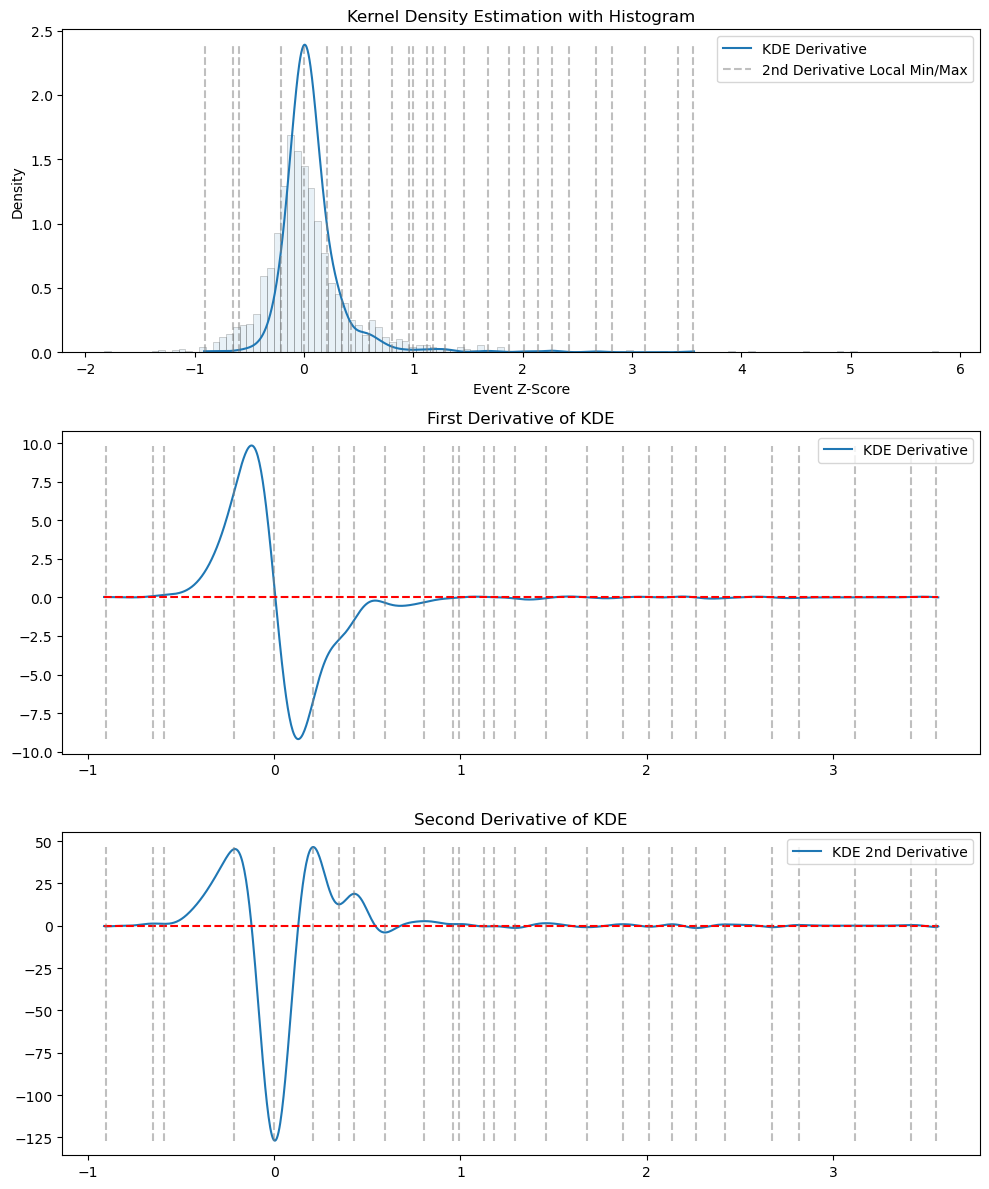

Local minima and maxima from second derivative: [-9.05049169e-01 -6.49434446e-01 -5.91136351e-01 -2.14440970e-01
  8.13533973e-04  2.07099100e-01  3.46117634e-01  4.26838073e-01
  5.92763419e-01  8.03533454e-01  9.60489863e-01  9.91881145e-01
  1.12641521e+00  1.18022884e+00  1.29234056e+00  1.45826590e+00
  1.67800488e+00  1.87083703e+00  2.01434004e+00  2.13542070e+00
  2.26547029e+00  2.42242670e+00  2.67355695e+00  2.81705996e+00
  3.11751937e+00  3.41797878e+00  3.55251284e+00]


In [45]:
# Calculate KDE and its derivatives
kde = gaussian_kde(merged_df['Z-score'])
x = np.linspace(min(merged_df['Z-score']), max(merged_df['Z-score']), 1000)
kde_values = kde(x)
kde_derivative = np.gradient(kde_values, x)
kde_second_derivative = np.gradient(kde_derivative, x)

# Find local minima and maxima of the second derivative
second_derivative_sign_changes = np.diff(np.sign(np.gradient(kde_second_derivative, x)))
local_minima_maxima = x[:-1][np.where(second_derivative_sign_changes != 0)[0]]

# Plot the KDE, its first derivative, and its second derivative with local minima and maxima marked
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Plot KDE with histogram using sns.histplot
sns.histplot(rewarded_zscores['Event Z-Score'], ax=ax[0], stat='density', alpha=0.1, edgecolor=(0, 0, 0, 0.3))
ax[0].plot(x, kde_values, label='KDE Derivative')
ax[0].set_title('Kernel Density Estimation with Histogram')
ax[0].vlines(local_minima_maxima, ymin=0, ymax=max(kde_values), color='grey', linestyle='--', alpha=0.5, label='2nd Derivative Local Min/Max')
ax[0].legend()

# Plot first derivative of KDE
ax[1].plot(x, kde_derivative, label='KDE Derivative')
ax[1].set_title('First Derivative of KDE')
ax[1].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[1].vlines(local_minima_maxima, ymin=min(kde_derivative), ymax=max(kde_derivative), color='grey', linestyle='--', alpha=0.5)
ax[1].legend()

# Plot second derivative of KDE
ax[2].plot(x, kde_second_derivative, label='KDE 2nd Derivative')
ax[2].set_title('Second Derivative of KDE')
ax[2].hlines(0, x.min(), x.max(), color='red', linestyle='--')
ax[2].vlines(local_minima_maxima, ymin=min(kde_second_derivative), ymax=max(kde_second_derivative), color='grey', linestyle='--', alpha=0.5)
ax[2].legend()

plt.tight_layout()
plt.show()

# Print the local minima and maxima points from the second derivative
print("Local minima and maxima from second derivative:", local_minima_maxima)

In [49]:
zscore_df

,Recording,Event name,Unit number,Z-score
0,20230612_101430_standard_comp_to_training_D1_s...,lose,2,-0.024142
1,20230612_101430_standard_comp_to_training_D1_s...,lose,5,-0.117428
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,0.075553
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,0.033169
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,0.091453
...,...,...,...,...
797,20230625_112913_standard_comp_to_both_rewarded...,win,60,0.281825
798,20230625_112913_standard_comp_to_both_rewarded...,win,77,0.035138
799,20230625_112913_standard_comp_to_both_rewarded...,win,85,0.065548
800,20230625_112913_standard_comp_to_both_rewarded...,win,99,-0.049478


In [51]:
zscorearray = zscore_df['Z-score']

In [52]:
zscorearray

0     -0.024142
1     -0.117428
2      0.075553
3      0.033169
4      0.091453
         ...   
797    0.281825
798    0.035138
799    0.065548
800   -0.049478
801   -0.013065
Name: Z-score, Length: 802, dtype: object

In [54]:
type(zscorearray)

pandas.core.series.Series

In [63]:
# Convert the 'Z-score' series to numeric, coercing errors to NaN
zscorearray = pd.to_numeric(zscorearray, errors='coerce')

# Now, sort the values
zscoreorder = zscorearray.sort_values()

In [64]:
zscoreorder

498   -0.914018
518   -0.767719
758   -0.606148
236   -0.521558
247   -0.495427
         ...   
167         NaN
282         NaN
486         NaN
522         NaN
527         NaN
Name: Z-score, Length: 802, dtype: float64

In [65]:
zscoreorder.min()

-0.9140181066893388

In [66]:
zscoreorder.max()

3.5659662512619446